# Chapter 3: Design of gRNA targeting genetic variants across HIV-1 subtypes for CRISPR-mediated antiviral therapy

In [1]:
import pandas as pd
from pandarallel import pandarallel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sbn
sbn.set(style='ticks', font_scale=1.5)
sbn.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
%matplotlib inline
import imp
import sgrna_finder
from collections import OrderedDict
from scipy import stats
from tqdm import tqdm
from tempfile import TemporaryDirectory, NamedTemporaryFile
from subprocess import check_call, check_output
import shlex
import glob
import re
from Bio.Seq import Seq, reverse_complement
from Bio.Alphabet import DNAAlphabet, RNAAlphabet, generic_nucleotide
from Bio import SeqIO
from sklearn import metrics, linear_model

from datetime import datetime
curdate = str(datetime.now()).split(' ')[0].replace('-', '')
import os
if not os.path.exists('../processed_data/%s' % curdate):
    os.mkdir('../processed_data/%s' % curdate)

import warnings
warnings.filterwarnings("ignore")

# temp import 
import sys
try: 
    sys.path.append('/data/crseek')
except ImportError:
    print("Download crseek to data folder or assign a path for importing crseek")
from crseek import estimators, utils, preprocessing, annotators, evaluators

import lanl_preprocessing
import func

import sys
sys.path.append('/data/hiv-crispr-review/')
import FigureTools

In [414]:
imp.reload(sgrna_finder)

<module 'sgrna_finder' from '/home/james/damnotebooks/projects/HIVsubtSMRT/code/sgrna_finder.py'>

In [2]:
wrapper = sgrna_finder.lanl_demograph_wrap('../../HIVsubtSMRT/raw_data/HIV_LANL_all.txt')
dfLANL = wrapper.ret_df()

In [238]:
s = pd.read_csv('../../onTarget/processed_data/20190708/20190708_possible_spacer_freq_allSubtypesLANL.csv', 
                index_col=0, squeeze=True, header=None)
s

0
AAAAUAUUCAUAAUGAUAGU    37790
AAACAGAAGCGCAUAAUGUC        5
AAAUUAUAAACAUGUGGCAG     9010
AACAACUUUACAAAAAGUAG       10
AACAGAAGCGCAUAAUGUCU        5
                        ...  
GGCUGCCCACAAAUCUCUAU        1
GGGCUGCCCACAAAUCUCUA        1
UACUAAUACUGUACCUAUAG        1
UAUGGGUAUCUGAUCAUACU        1
CUCAGAUUGGUUAUUCUUUA        1
Name: 1, Length: 3651565, dtype: int64

In [250]:
(s<100).sum() / len(s)

0.9807027945552113

In [50]:
listtypes = ['B', 'C', 'A', '01_AE', '02_AG', 'G', 'D', 'F', 'Others']
#listtypes = ['Others',]
ref = '/data/index/HXB2Sequence.fasta'
#for k, gp in dfLANL[dfLANL['assigned_subtype'].isin(listtypes)].groupby('assigned_subtype'):


#name = 'HIV_subtype%s'%k
name = 'HIV_subtypesALL'
gp = dfLANL
#subfile = os.path.abspath('../processed_data/HIV_subtype%s.fasta'%k)
subfile = os.path.abspath('/data/HIV_ALL/bam/HIV_all.fasta')
with open(subfile, 'w') as handle:
    for idx, row in tqdm(gp.iterrows()):
        handle.write('>%s\n'%row['GI number'])
        handle.write('%s\n'%row['Sequence'].seq)
with TemporaryDirectory(dir='/tmp') as tmpdir:
    tmpf = os.path.join(tmpdir, name)
    cmd = 'bwa mem -t 7 %s %s -o %s.sam'%(ref, subfile, tmpf)
    check_call(shlex.split(cmd))
    cmd = 'samtools sort -@8 -o %s.bam %s.sam' % (tmpf, tmpf)
    print(cmd)
    check_call(shlex.split(cmd))
    cmd = 'samtools index %s.bam'% (tmpf)
    check_call(shlex.split(cmd))
    cmd = 'cp %s.bam* ../processed_data/.' % tmpf
    check_call(cmd, shell=True)

777604it [01:55, 6738.15it/s]


samtools sort -@8 -o /tmp/tmpaahpfg59/HIV_subtypesALL.bam /tmp/tmpaahpfg59/HIV_subtypesALL.sam


## Calculate diversity and coverage

100%|██████████| 10/10 [16:42<00:00, 100.26s/it]


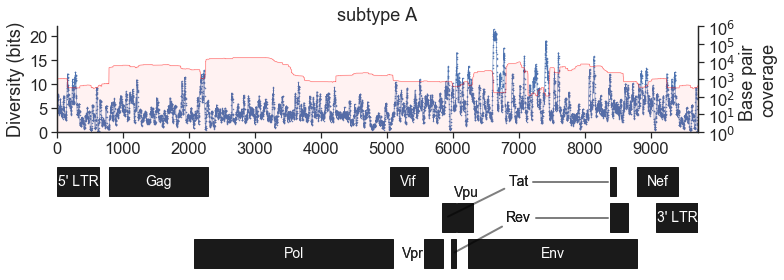

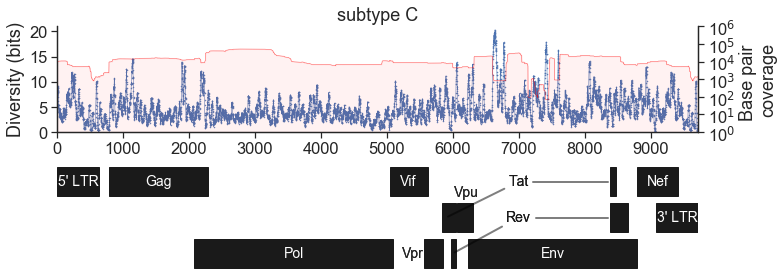

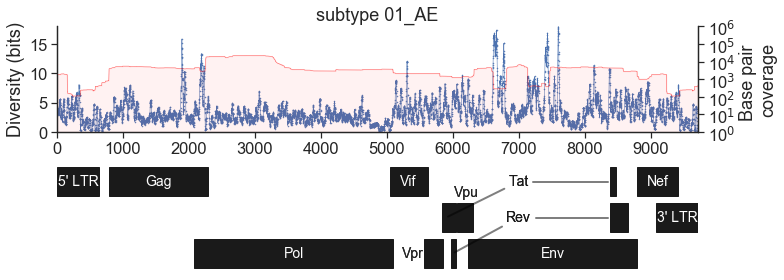

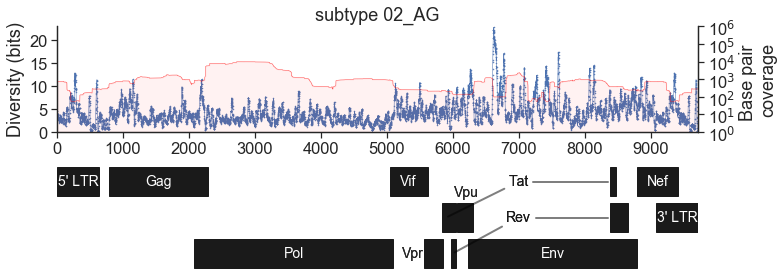

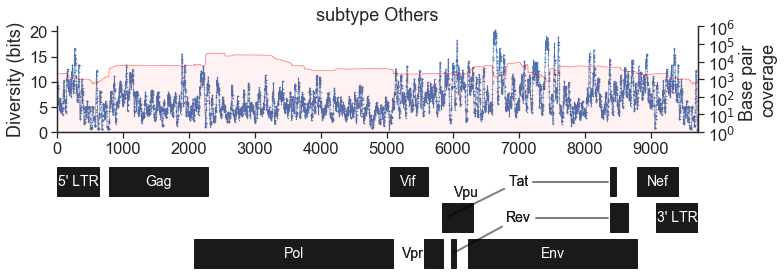

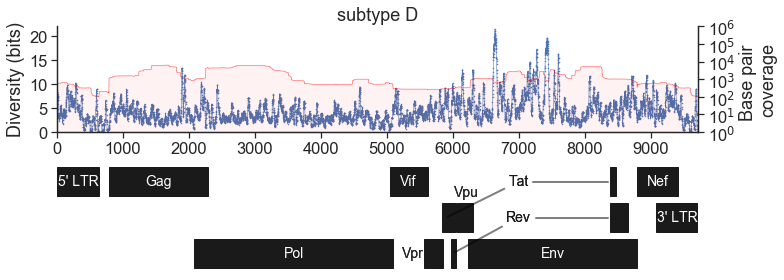

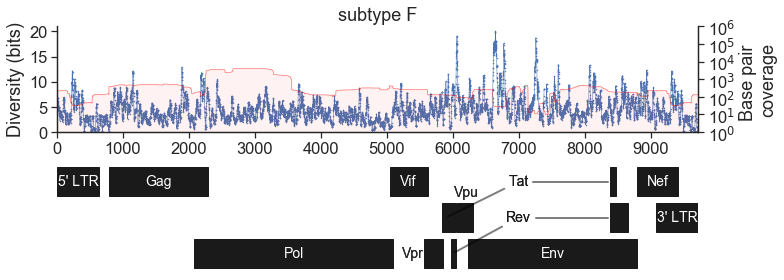

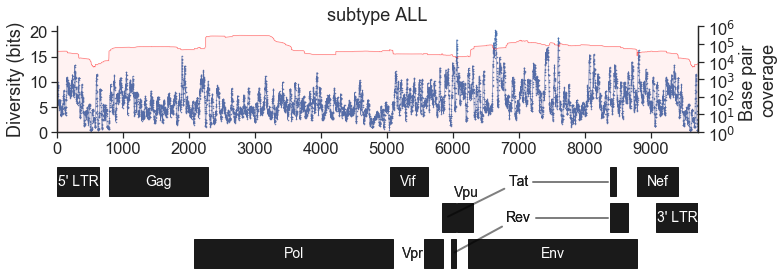

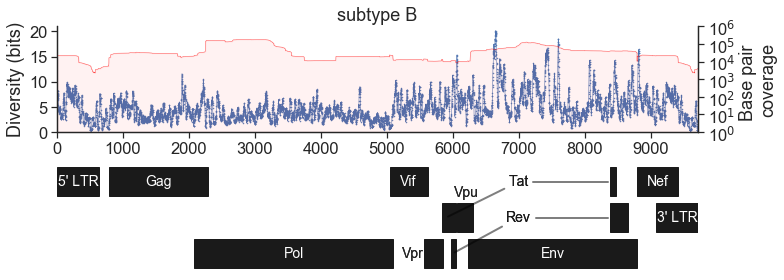

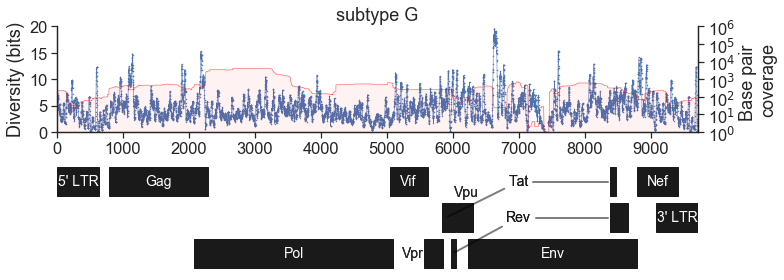

In [3]:
files = glob.glob('../processed_data/bams/*.bam')
dfcov = pd.DataFrame()
dfdiv = pd.DataFrame()

for f in tqdm(files):
    n = f.split('/')[-1].split('.')[0].replace('HIV_subtype', '')
    ncov = '%s_cov'%n
    ndiv = '%s_div'%n
    div_whole2, cov_whole2 = lanl_preprocessing.cal_cov_div_LTR(f, 
                            region=[('HXB2', '1', '9720'), ], window=20, 
                            LTRagg=True)#, datapath=os.path.abspath('../processed_data/'))  
    #div_whole2 = div_whole2 #+ div_whole2[:635]
    #cov_whole2 = cov_whole2 #+ cov_whole2[:635]
    dfcov[ncov] = cov_whole2
    dfdiv[ndiv] = div_whole2
    fig, axes = plt.subplots(2,1, figsize=(11,4))

    for idx, ax in enumerate(axes.flatten()):
        if idx==0:
            ax.plot(div_whole2, '.-', markersize=1, linewidth=.5)

            ax.set_ylim(0, np.ceil(max(div_whole2)))
            ax.set_xlim(0, 9719)
            ax.locator_params(nbins=10, axis='x')
            ax.locator_params(nbins=7, axis='y')
            #ax.set_xlabel('HIV coordinate, bp')
            ax.set_ylabel('Diversity (bits)')
            ax.set_title('subtype %s'% n)
            ax_app = ax.twinx()
            ax_app.plot(np.log10(cov_whole2), '-', markersize=1, linewidth=.5, alpha=.7, color='red')
            ax_app.set_ylabel('Base pair \ncoverage')
            ax_app.set_ylim(0, 6)
            ax_app.locator_params(nbins=8, axis='y')
            ax_app.set_yticklabels(['10$^%d$'%x for x in ax_app.get_yticks()])
            ax_app.fill_between(range(0,len(cov_whole2)), np.log10(cov_whole2), color='red', alpha=.05)
        elif idx==1:
            ax = FigureTools.generate_hiv_orfs(ax)
    sbn.despine(right=False)
    fig.tight_layout()
    fig.savefig('../processed_data/%s/%s_HIV_subtype%s_div.png'% (curdate, curdate, n), dpi=300)

#print(files)

In [271]:
dfcov.to_csv('../processed_data/%s_dfcov_AllSubtypes.csv'%curdate)
dfdiv.to_csv('../processed_data/%s_dfdiv_AllSubtypes.csv'%curdate)

In [8]:
dfdiv.columns

Index(['A_div', 'C_div', '01_AE_div', '02_AG_div', 'Others_div', 'D_div',
       'F_div', 'ALL_div', 'B_div', 'G_div'],
      dtype='object')

In [12]:
dfdiv['B_div'].describe()

count    9720.000000
mean        4.868809
std         2.739412
min         0.012670
25%         2.972373
50%         4.295964
75%         6.113411
max        20.139680
Name: B_div, dtype: float64

In [13]:
dfdiv['ALL_div'].describe()

count    9720.000000
mean        6.155702
std         2.930995
min         0.013332
25%         4.061588
50%         5.644517
75%         7.857818
max        20.210098
Name: ALL_div, dtype: float64

In [11]:
(dfdiv['ALL_div']<3).sum()/9720

0.10812757201646091

## Construct spacer table

In [ ]:
# Global subtype distribution [PMID:30509777]
subtypes = {'A': 10.2,
            'B': 12.1,
            'C': 46.6,
            'D': 2.7,
            'F': 0.6,
            'G': 4.6,
            '01_AE': 5.3,
            '02_AG': 7.8,
            'Others': 10.1 }  #,
            #'global': 100}    

# Collect PVC from runs
on_cutoff=0.569
col1 = ['%s_CFD'%k for k in sorted(subtypes.keys())] #+ ['%s_PatCured'%k for k in sorted(subtypes.keys())]
col1.append('Global_CFD')
col3 = ['%s_SubCured'%k for k in sorted(subtypes.keys())]
col3.append('Global_SubCured')
col2 = ['%s_PatCured'%k for k in sorted(subtypes.keys())]
col2.append('Global_PatCured')
cols=col1+ col3 +col2
dfResult = pd.DataFrame(columns = cols)



for idx, spa in tqdm(enumerate(list(glob.glob('../processed_data/top1330_grnas/*.csv'))), total=1330, ascii=True, unit='spacer'):
#for idx, spa in tqdm(enumerate(list(glob.glob('../../CRISPRcard/processed_data/Published_450gRNAs/*pat'))), total=1330, ascii=True, unit='spacer'):
    out = pd.read_csv(spa, index_col=0)
    grna_seq = spa.split('/')[-1].split('.')[0]
    
    out = pd.concat([out, dfLANL[['PAT id(SSAM)', 'Accession', 'assigned_subtype']]], axis=1)
    out = out[out['score'].notnull()]
    out = sgrna_finder.calPatFreq(out)
    out['PAT id(SSAM)'] = out['PAT id(SSAM)'].fillna(out['Accession'])
    
    # avg CFD
    avg_CFD = out.groupby('assigned_subtype').apply(lambda x: (x['PATid_freq'] * (x['score'])).sum() / x['PATid_freq'].sum())
    total_CFD = np.array([v*subtypes[idx] for idx, v in avg_CFD.iteritems()]).sum()/100
    avg_CFD = avg_CFD.append(pd.Series(total_CFD, index=['Global_CFD']))
    avg_CFD = pd.Series(avg_CFD, name=grna_seq)
    avg_CFD.index = col1
    
    # percent cured subtypes
    sub_CFD = out.groupby('assigned_subtype').apply(lambda x: (x['PATid_freq'] * (x['score']>on_cutoff)).sum() / x['PATid_freq'].sum())
    total_CFD = np.array([v*subtypes[idx] for idx, v in sub_CFD.iteritems()]).sum()/100
    sub_CFD = sub_CFD.append(pd.Series(total_CFD, index=['Global_SubCured']))
    sub_CFD = pd.Series(sub_CFD, name=grna_seq)
    sub_CFD.index = col3
    
    # percent cured patients
    #out['PatCured'] = out.groupby('PAT id(SSAM)')['score'].transform(lambda x: ((x>on_cutoff).sum()/len(x)))
    #out.to_csv('../processed_data/%s/%s.patcured'%(curdate, grna_seq))
    out = pd.read_csv('../processed_data/PatientCuredRate/%s.patcured'%grna_seq, index_col=0)
    sub_pat = out.groupby('assigned_subtype')['PatCured'].apply(lambda x: x.sum()/len(x))
    total_pat = np.array([v*subtypes[idx] for idx, v in sub_pat.iteritems()]).sum()/100
    sub_pat = sub_pat.append(pd.Series(total_pat, index=['Global_PatCured']))
    sub_pat = pd.Series(sub_pat, name=grna_seq)
    sub_pat.index = col2
    
    
    
    dfResult = dfResult.append(pd.concat([avg_CFD, sub_CFD, sub_pat], axis=0))
dfResult.to_csv('../processed_data/%s_PubgRNAs_SubCured_PatCured.csv'%curdate)    

In [ ]:
# Add spacer column
dfResult = dfResult.reset_index(drop=False)
dfResult = dfResult.rename(columns={'index':'spacer'})
dfResult['spacer'] = dfResult['spacer'].apply(lambda x: Seq(x, alphabet=RNAAlphabet()))

# Add target sites
dfResult = sgrna_finder.add_targetsite(dfResult)

# Add diversity
dfdiv['clv_site'] = np.arange(1,(dfdiv.shape[0]+1))
dfResult = pd.merge(dfResult, dfdiv, on='clv_site', how='left')

# Add off-target counts
#pos_flat = pd.read_csv('../processed_data/20190708_spacers.AllSubtypesLANL.casoff.output')
#pos_flat['spacer'] = pos_flat['spacer'].apply(lambda x: Seq(x, alphabet=RNAAlphabet()))
#pos_flat['target'] = pos_flat['target'].apply(lambda x: Seq(x, alphabet=DNAAlphabet()))
#pos_flat['offcount'] = sgrna_finder.est_off_score(pos_flat, 'CFD')
#pos_flat.to_csv('../processed_data/%s_spacers.AllSubtypesLANL.casoff.offcount'%curdate)
pos_flat = pd.read_csv('../processed_data/20200131_spacers.AllSubtypesLANL.casoff.offcount')
seOFF = pos_flat[pos_flat['offcount']>on_cutoff].groupby('spacer')['offcount'].count()
seOFF = seOFF.rename('offcount')
dfResult = pd.merge(dfResult, seOFF, how='left', left_on='spacer', right_index=True, sort=False)
dfResult.loc[dfResult['offcount'].isnull(), 'offcount'] = 0

# Add Cas9 column
dfResult['Cas9'] = 'SpCas9'

# 

In [228]:
# Add hex identifier
dfResult['g5to3'] = dfResult['spacer'].apply(lambda x: str(x.back_transcribe()+ 'NGG'))
dfResult = func.get_hex(dfResult)

# Add region
dfResult = func.get_region(dfResult)

# Add previously published
dfpubs = pd.read_excel('../../CRISPRcard/processed_data/20200126_450pubs_gRNAs_complete.xlsx')
dfResult['inPubs'] = dfResult['hex'].isin(dfpubs['hex'])

# Add inHXB2
hxb2_spacers = sgrna_finder.sgrna_hxb2('../raw_data/HXB2Sequence.fasta')
dfResult['inHXB2'] = dfResult['spacer'].isin(hxb2_spacers)
jlat_spacers = sgrna_finder.sgrna_hxb2('../raw_data/HIV_R7_Eneg_eGFP_inJLat10_6.fasta')
dfResult['inJLat'] = dfResult['spacer'].isin(jlat_spacers)
nl43_spacers = sgrna_finder.sgrna_hxb2('../raw_data/NL43_from_AF324493.2.fasta')
dfResult['inNL43'] = dfResult['spacer'].isin(nl43_spacers)

In [ ]:
refss = [('../raw_data/NL43_from_AF324493.2.fasta', 'NL43'),
         ('../raw_data/HXB2Sequence.fasta', 'HXB2'),
         ('../raw_data/HIV_R7_Eneg_eGFP_inJLat10_6.fasta', 'JLat')]
dftmp = dfResult.copy(deep=True)
for r, n in refss:
    dftmp = sgrna_finder.inref(dftmp, r, n)

In [439]:
dftmp['refseq_NL43']

586    GTGGGTCACAGTCTATTATGGGG
587    AGCAGTTGAGTTGATACTACTGG
588    AGAACCTCCATTCCTTTGGATGG
589    GCTGCCAAAGAGTGATCTGAGGG
Name: refseq_NL43, dtype: object

In [83]:
ref = '../raw_data/NL43_from_AF324493.2.fasta'
with open(ref) as handle:
    refseq = list(SeqIO.parse(handle, 'fasta'))[0]
    
#refseq.seq = refseq.seq[155:200]
#refseq.seq

In [118]:
refseq.seq[2375:2398]#.reverse_complement()

Seq('TGGAAACCAAAAATGATAGGGGG', SingleLetterAlphabet())

In [ ]:
dfResult = dfResult.rename(columns={'index':'name'})
dfResult['name'] = dfResult['name'].apply(lambda x: 'gRNA%s'%x)
dfResult.head()

In [3]:
dfResult = pd.read_csv('../processed_data/20200203_complete_1330_PatCured_SubCured_AvgCFD_gRNAs.csv', index_col=0)

In [4]:
dfResult.head()

,name,spacer,01_AE_CFD,02_AG_CFD,A_CFD,B_CFD,C_CFD,D_CFD,F_CFD,G_CFD,...,offcount,Cas9,g5to3,hex_full,hex,Region,inPubs,inHXB2,inJLat,inNL43
0,gRNA0,GGGACAGCAGAGAUCCACUU,0.193652,0.133299,0.324257,0.611738,0.021870,0.389888,0.052996,0.139720,...,1.0,SpCas9,GGGACAGCAGAGATCCACTTNGG,6e18406fdb91d5727610a49b5dd7c704,6e1840,"Pol,IN",False,False,False,False
1,gRNA1,UUCUUUUUAAAAGAAAAGGG,0.491792,0.434615,0.412606,0.422278,0.360205,0.449966,0.490872,0.461931,...,41.0,SpCas9,TTCTTTTTAAAAGAAAAGGGNGG,3c2f561d5af740e0732fe1d9880f7cc0,3c2f56,Nef,False,False,False,False
2,gRNA2,CGGAUUCUUAGCACUUGCCU,0.427354,0.571160,0.638338,0.246985,0.539055,0.415704,0.161314,0.416142,...,1.0,SpCas9,CGGATTCTTAGCACTTGCCTNGG,2c5cbbcb4a4622042362340bb3a23b6e,2c5cbb,"Rev2,Env,gp41",False,False,False,False
3,gRNA3,AGUAUGGGCAAGCAGGGAGC,0.196216,0.702149,0.904632,0.241762,0.703861,0.250438,0.214655,0.842371,...,3.0,SpCas9,AGTATGGGCAAGCAGGGAGCNGG,0c51ab52c6990d3f2ffd642761d94f12,0c51ab,"Gag,p17",False,False,False,False
4,gRNA4,AUCAACAGCUCCUAGGGAUU,0.137183,0.803131,0.806207,0.586081,0.655006,0.721897,0.433231,0.807078,...,1.0,SpCas9,ATCAACAGCTCCTAGGGATTNGG,ae9eef2a1a8a133e260d36f375c2f086,ae9eef,"Env,gp41",False,False,False,False


In [17]:
dfResult[(dfResult['global_CFD']>0.8) & (dfResult['B_div']<2)].transpose().shape

(35, 16)

In [31]:
dfResult[dfResult['start']==2376]['spacer']

14      UGGAAGCCAAAAAUGAUAGG
1293    UGGAAACCAAAAAUGAUAGG
Name: spacer, dtype: object

## Correlation tests between evaluators

0.03950701778570685
0.9747131256724988 0.0
0.2944864359667067
0.24205999325188557 5.306512627319823e-82
0.41111359644971807
0.03889478729309274 3.958109864283523e-13


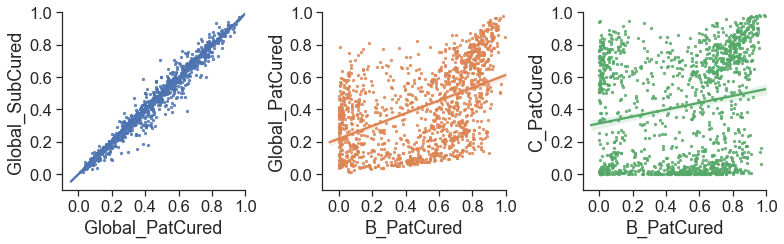

In [50]:
yys = ['Global_SubCured', 'Global_PatCured', 'C_PatCured']
xxs = ['Global_PatCured', 'B_PatCured', 'B_PatCured']
fig, axes = plt.subplots(1,3, figsize=(11,3.5))
for xx, yy, ax in zip(xxs, yys, axes):
    sbn.regplot(data=dfResult, x=xx, y=yy, ax=ax, scatter_kws={'s':5})
    mse = metrics.mean_squared_error(dfResult[xx], dfResult[yy])
    print(mse**0.5)
    #reg = linear_model.LinearRegression().fit(dfResult[xx], dfResult[yy])
    _, _, r, pval, _ = stats.linregress(dfResult[xx], dfResult[yy])
    print(r**2, pval)
    ax.locator_params(nbins=6, axis='y')
    ax.set_ylim(-.1, 1)
    ax.locator_params(nbins=6, axis='x')
    ax.set_xlim(-.1, 1)
sbn.despine()
fig.tight_layout()
fig.savefig('../processed_data/%s/%s_vs_combined.png'%(curdate, curdate), dpi=300)

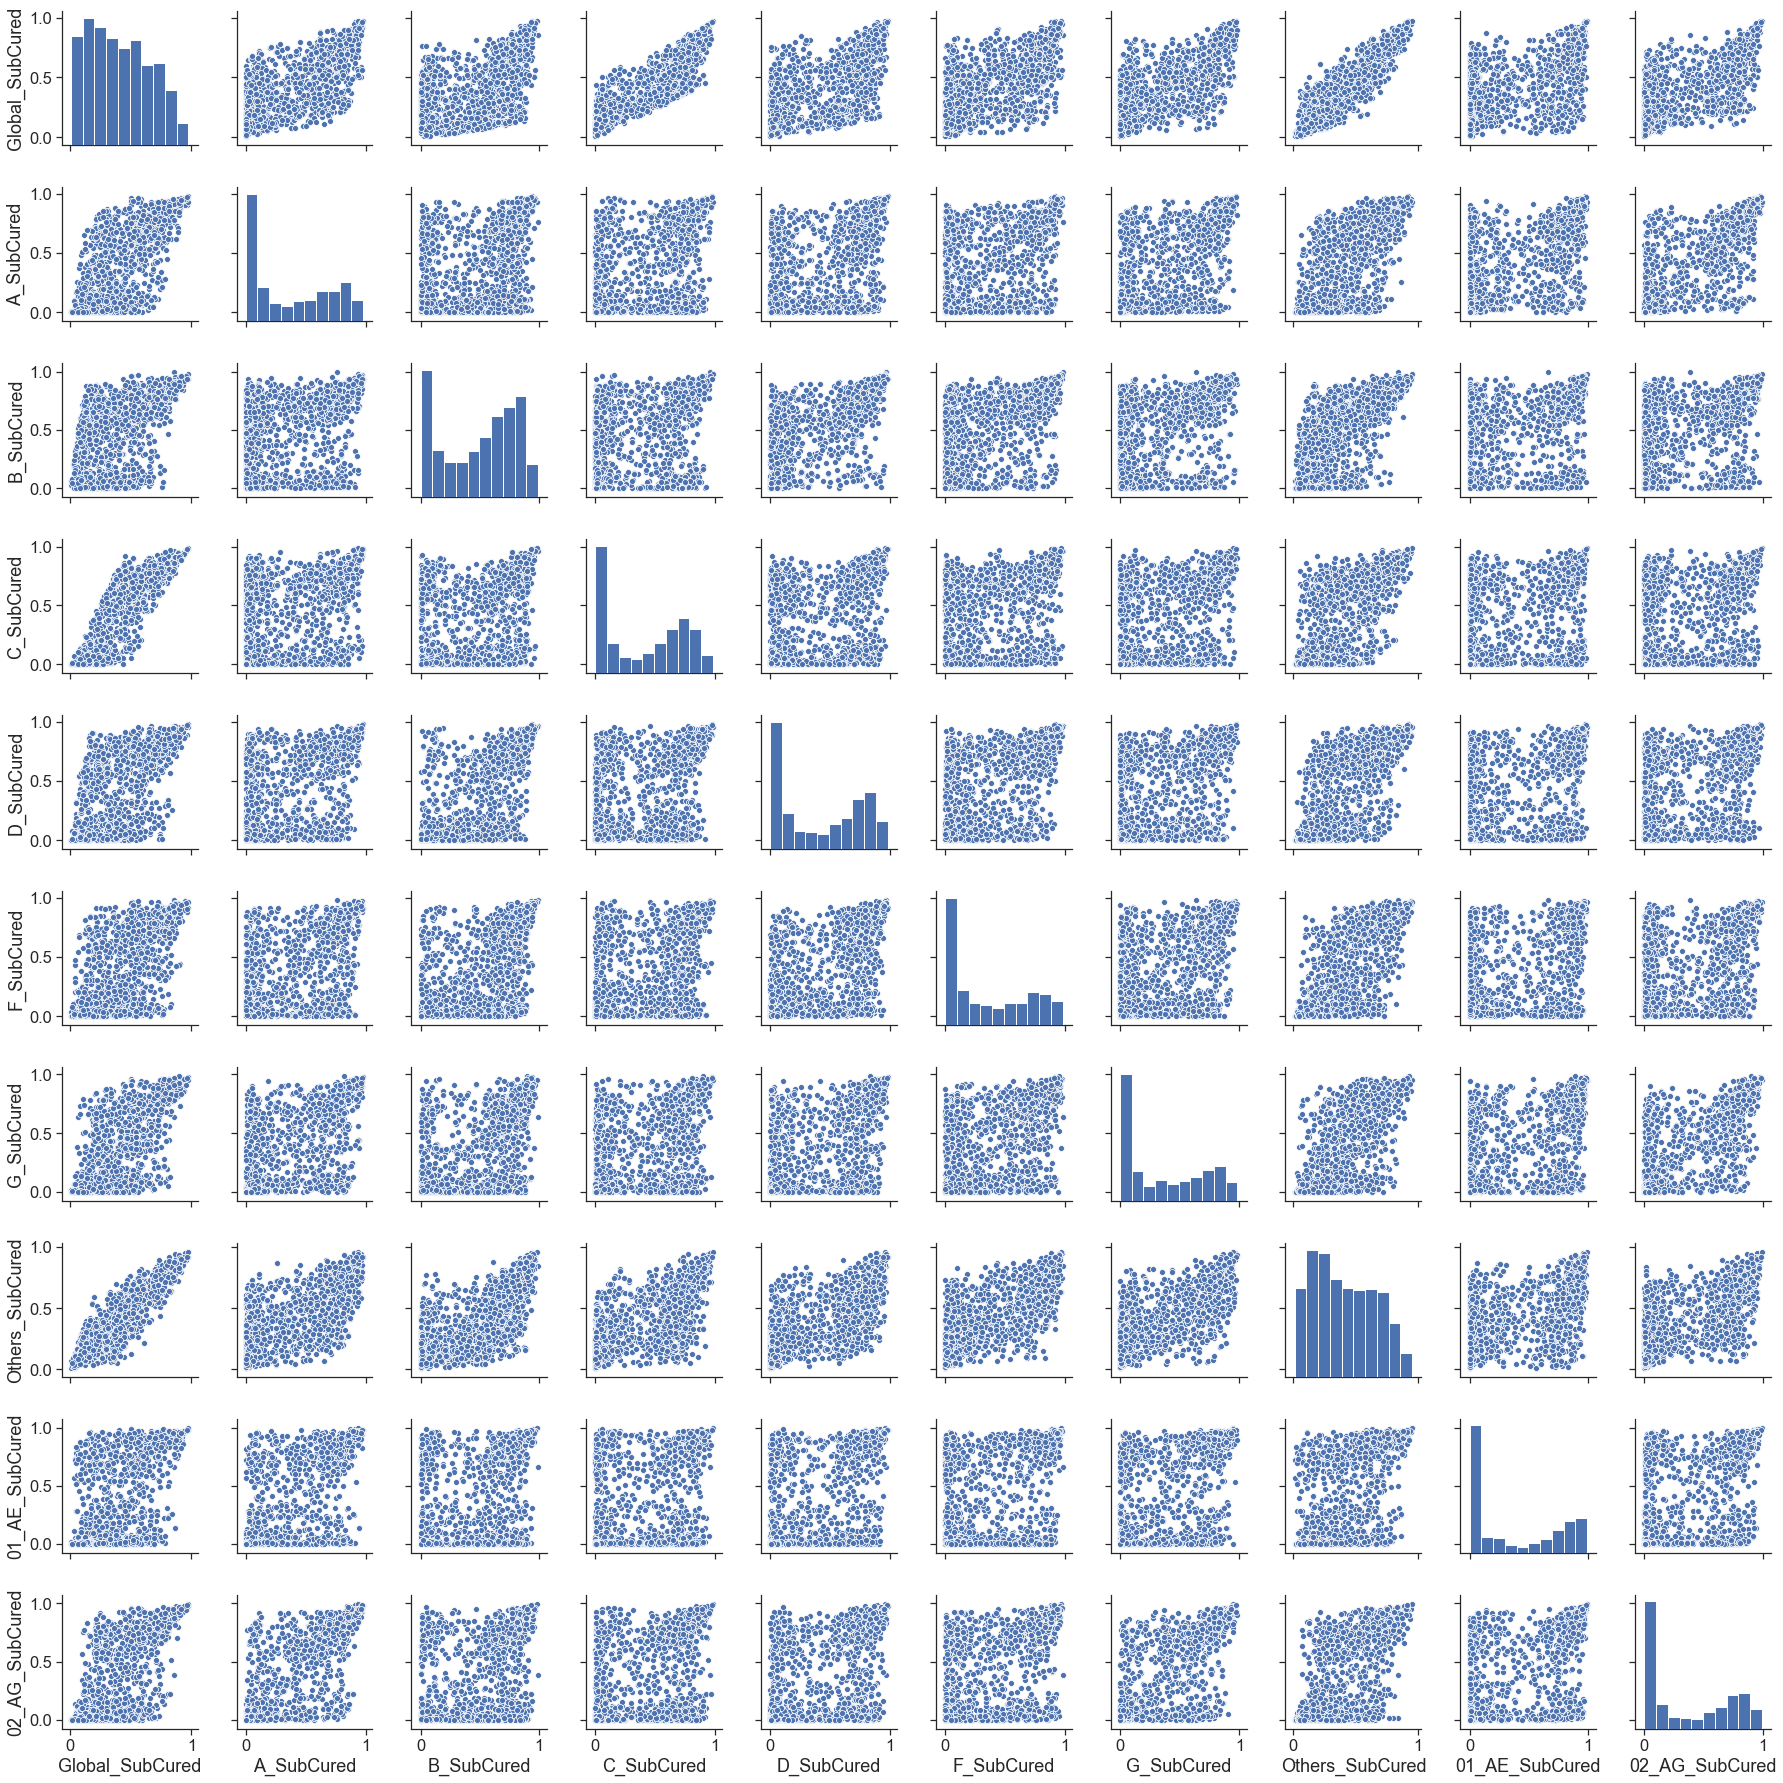

In [270]:
#fig, ax = plt.subplots(1,1, figsize=(10,10))
reg = re.compile('.*_SubCured')
cols = sorted([ x for x in list(dfResult.columns) if reg.match(x)])
cols = cols[2:] + cols[:2]
g = cols[6]
cols = cols[:6] + cols[7:]
cols.insert(0, g)
cols
dftmp = dfResult[cols]
fg = sbn.pairplot(data=dftmp)
fg.savefig('../processed_data/%s/%s_SubCured_FacetGrid.png'%(curdate, curdate), dpi=300)

## Diversity vs patient coverage

No handles with labels found to put in legend.


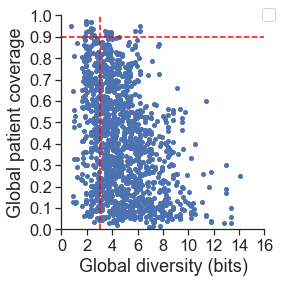

In [8]:
fig , ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(dfResult['ALL_div'], dfResult['Global_SubCured'], 
        'o', markersize=4, zorder=0)
#dftmp = dfResult[dfResult['inHXB2']==True]
#ax.plot(dftmp['B_div'], dftmp['global_CFD'], 
#        'o', markersize=4, label='Identical')
ax.set_ylim(0,1)
ax.set_xlim(0,16)
ax.hlines(y=0.9, xmin=0, xmax=16, linestyles='dashed', colors='red')
ax.vlines(x=3, ymin=0, ymax=1, linestyles='dashed', colors='red', zorder=1)
ax.locator_params(nbins=10, axis='y')
ax.locator_params(nbins=10, axis='x')
ax.set_xlabel('Global diversity (bits)')
ax.set_ylabel('Global patient coverage')
fig.legend()
sbn.despine()
fig.tight_layout()
fig.savefig('../processed_data/%s/%s_scatter_div_vs_patcov.png'%(curdate, curdate), dpi=300)

In [10]:
dfResult.columns

Index(['name', 'spacer', '01_AE_CFD', '02_AG_CFD', 'A_CFD', 'B_CFD', 'C_CFD',
       'D_CFD', 'F_CFD', 'G_CFD', 'Others_CFD', 'Global_CFD', '01_AE_SubCured',
       '02_AG_SubCured', 'A_SubCured', 'B_SubCured', 'C_SubCured',
       'D_SubCured', 'F_SubCured', 'G_SubCured', 'Others_SubCured',
       'Global_SubCured', '01_AE_PatCured', '02_AG_PatCured', 'A_PatCured',
       'B_PatCured', 'C_PatCured', 'D_PatCured', 'F_PatCured', 'G_PatCured',
       'Others_PatCured', 'Global_PatCured', 'strand', 'start', 'stop',
       'clv_site', 'A_div', 'C_div', '01_AE_div', '02_AG_div', 'Others_div',
       'D_div', 'F_div', 'ALL_div', 'B_div', 'G_div', 'offcount', 'Cas9',
       'g5to3', 'hex_full', 'hex', 'Region', 'inPubs', 'inHXB2', 'inJLat',
       'inNL43'],
      dtype='object')

## Targeting efficiency across subtyeps using lead gRNAs

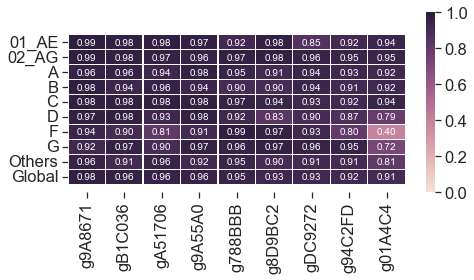

In [17]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

cmap = sbn.cubehelix_palette(as_cmap=True, light=0.9)
cmap.set_under("0.8")

dftmp = dfResult[(dfResult['ALL_div']<3.01) & (dfResult['Global_PatCured']>0.9)]
reg = re.compile('.*_PatCured')
cols = sorted([ x for x in list(dfResult.columns) if reg.match(x)])
g = cols[8:]
g = g[::-1]
cols = cols[:8] + g
cols = cols[::-1]
#cols = cols[2:] + cols[:2]
#g = cols[6]
#cols = cols[:6] + cols[7:]
#cols.insert(0, g)

cols.insert(0, 'hex')
labs = [x.replace('_PatCured', '') for x in cols[1:]]
dftmp = dftmp[cols]
dftmp['hex'] = dftmp['hex'].apply(lambda x: 'g'+x.upper())
dftmp = dftmp.sort_values(by='Global_PatCured', ascending=False)
sbn.heatmap(dftmp.iloc[:,1:].transpose(), 
                ax=ax, cmap=cmap,
                vmax=1, vmin=0.0,
                linewidth=0.3,
                xticklabels= dftmp['hex'],
                yticklabels=labs,
            annot=True, fmt=".2f")
ax.set_yticklabels(ax.get_yticklabels(), va='center')
ax.set_ylim(-.5, dftmp.shape[1]+.5)
fig.tight_layout()
fig.savefig('../processed_data/%s/%s_top9_heatmap_patcured.png'%(curdate, curdate), dpi=300)

In [23]:
dftmp = dfResult[(dfResult['ALL_div']<3.01) & (dfResult['Global_PatCured']>0.9)].sort_values(by='Global_PatCured', ascending=False)
dftmp[['ALL_div', 'hex']]

,ALL_div,hex
589,1.910192,9a8671
1293,2.364670,b1c036
34,1.910192,a51706
14,2.364670,9a55a0
428,0.760944,788bbb
695,2.865761,8d9bc2
476,2.105688,dc9272
626,1.931119,94c2fd
932,1.851978,01a4c4


In [ ]:
dftmp.sort_values(by='Global_PatCured', ascending=False).transpose()

## Generate sequence visualization figures for each gRNAs
* 'identify' program was used from guideseq package for the figure generating
* input file format were copied from the guideseq output '*.identified' file and replace the info into gRNAs of interest

In [ ]:
dftmp = dfResult[(dfResult['start']==2255) & (dfResult['strand']=='-')] #.reset_index(drop=True)
#dftmp = dfResult[(dfResult['ALL_div']<3.01) & (dfResult['Global_PatCured']>0.9)]

for k, gp in tqdm(dfResult.groupby(['start', 'strand']), ascii=True, unit='grna'):
    dftmp = gp #pd.DataFrame()
    #dftmp = dftmp.append(gp)
    grna_seq = dftmp.loc[dftmp['Global_PatCured'].idxmax(), 'g5to3']
    gname = dftmp.loc[dftmp['Global_PatCured'].idxmax(), 'hex']
    gname = 'g' + gname.upper()
    dftmp = dftmp.reset_index(drop=True)
    #print(gname)
    template = pd.read_csv('../raw_data/template_input.csv', index_col=0)
    template = pd.concat([template]*dftmp.shape[0]).reset_index(drop=True)
    for idx, row in dftmp.iterrows():
        #print(row['name'], row['Global_PatCured'])
        template.loc[idx, 'Off-Target Sequence'] = row['g5to3']
        template.loc[idx, 'Target Sequence'] = grna_seq
        template.loc[idx, '#BED Chromosome'] = 'g' + row['hex'].upper()
        template.loc[idx, 'bi.sum.mi'] = row['Global_PatCured']
    #template[['Target Sequence', 'Off-Target Sequence']]
    template = template.sort_values(by='bi.sum.mi', ascending=False).reset_index(drop=True)
    datapath = '../processed_data/Tile_Visual'
    in_file = os.path.join(datapath, '%s_%s.input.csv' % (curdate, gname))
    template.to_csv(in_file, index=False, sep='\t')

    out_file = os.path.join(datapath, '%s_%s'%(curdate, gname))
    cmd = "/home/james/anaconda3/envs/guideseq/bin/python visualization.py %s %s '%s'"% (in_file, out_file, gname)
    #try:
    check_call(shlex.split(cmd))

## Generate sequence diversity plot flanked by gRNA-targeted regions

In [7]:
dfcov = pd.read_csv('../processed_data/%s_dfcov_AllSubtypes.csv'%curdate, index_col=0)
dfdiv = pd.read_csv('../processed_data/%s_dfdiv_AllSubtypes.csv'%curdate, index_col=0)

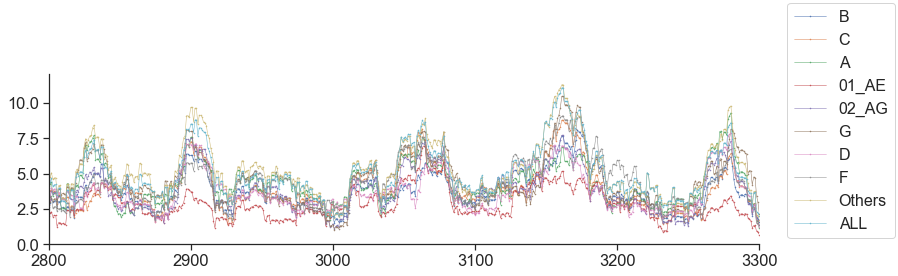

In [92]:
lims = (2800, 3300)
listtypes = ['B', 'C', 'A', '01_AE', '02_AG', 'G', 'D', 'F', 'Others', 'ALL']
colors = sbn.color_palette()
fig, ax = plt.subplots(1,1, figsize=(11,3))
for s in listtypes:
    ax.plot(dfdiv['%s_div'%s], '.-', markersize=1, linewidth=.5, label=s)

ax.set_ylim(0, np.ceil(dfdiv.iloc[lims[0] :lims[1] ,:-1].max().max()))
ax.locator_params(nbins=5, axis='y')
ax.set_xlim(lims[0], lims[1] )    
fig.legend(bbox_to_anchor=(1.14, 1.3), prop={'size':16})
sbn.despine()
fig.tight_layout()
fig.savefig('../processed_data/%s/%s_gRNA626_div_legends.png'%(curdate, curdate), dpi=300)#,bbox_inches='tight')

In [44]:
#dftmp = dfResult[(dfResult['ALL_div']<3.01) & (dfResult['Global_PatCured']>0.9)]
indlist = sorted([34, 1138, 626, 333, 1293])
dftmp = dfResult.iloc[indlist,:]
for idx, row in dftmp.iterrows():
    freqs = {}
    scores = {}
    out = pd.read_csv('../processed_data/top1330_grnas/%s.csv'%row['spacer'], index_col=0)
    out = out[out['score'].notnull()]
    out = out.pivot_table(index='target', values='score', aggfunc=['count', np.max])
    out.columns = out.columns.get_level_values(0)
    out = out.sort_values(by='count', ascending=False).reset_index()
    out['cumsum'] = out['count'].cumsum()
    #out['cum_freq'] = out['cumsum'].apply(lambda x: x/x.sum())
    out['cum_freq'] = out['cumsum'] / out['count'].sum()
    out['freq'] = out['count'] / out['count'].sum() * 100
    out['amax'] = np.round(out['amax'], 2)
    out = out.iloc[:((out['cum_freq']<0.95).sum()+1),:]
    out 
    #dftmp = out #pd.DataFrame()
    #dftmp = dftmp.append(gp)
    grna_seq = row['g5to3']#dftmp.loc[dftmp['Global_PatCured'].idxmax(), 'g5to3']
    gname = 'g' + row['hex'].upper() #dftmp.loc[dftmp['Global_PatCured'].idxmax(), 'name']
    #dftmp = dftmp.reset_index(drop=True)
    #print(gname)
    #print(out)
    template = pd.read_csv('../raw_data/template_input.csv', index_col=0)
    template = pd.concat([template]*out.shape[0]).reset_index(drop=True)
    for idxs, rowout in out.iterrows():
        #print(row['name'], row['Global_PatCured'])
        template.loc[idxs, 'Off-Target Sequence'] = rowout['target']
        template.loc[idxs, 'Target Sequence'] = grna_seq
        template.loc[idxs, '#BED Chromosome'] = rowout['amax']
        template.loc[idxs, 'bi.sum.mi'] = rowout['freq']
    #template[['Target Sequence', 'Off-Target Sequence']]
    template = template.sort_values(by='bi.sum.mi', ascending=False).reset_index(drop=True)
    datapath = '../processed_data/Hit_Freq/'
    in_file = os.path.join(datapath, '%s_%s.input.csv' % (curdate, gname))
    template.to_csv(in_file, index=False, sep='\t')

    out_file = os.path.join(datapath, '%s_%s'%(curdate, gname))
    cmd = "/home/james/anaconda3/envs/guideseq/bin/python visualization.py %s %s '%s'"% (in_file, out_file, gname)
    try:
        check_call(shlex.split(cmd))
    except:
        print('ss')